In [13]:
import base
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rushd as rd
import scipy as sp
import seaborn as sns

# enables concurrent editing of base.py
from importlib import reload
reload(base)

sns.set_style('ticks')
sns.set_context('talk',rc={'font.family': 'sans-serif', 'font.sans-serif':['Helvetica Neue']})

## Setup

- Load data
- Add metadata
- Draw gates
- Gate transfected cells

Result from this section: DataFrame `df` representing transfected cells.

Load all transfection data collected as of 2024.03.27

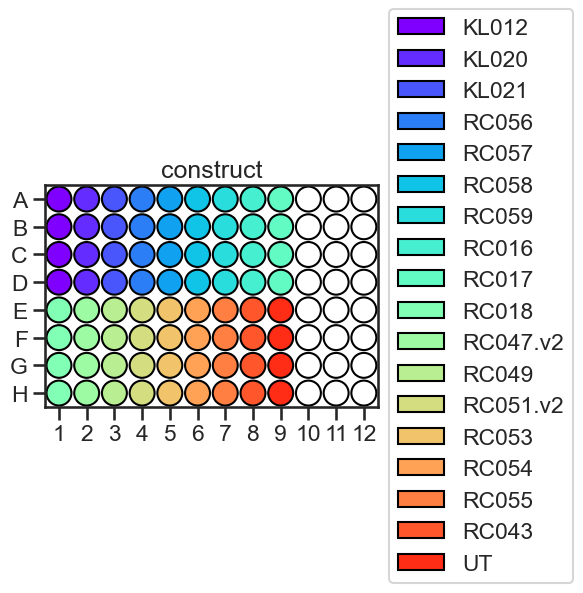

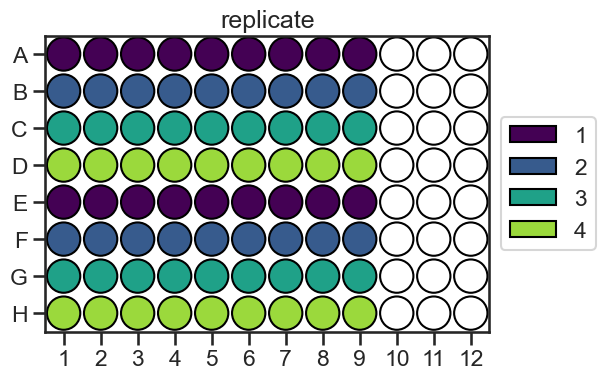

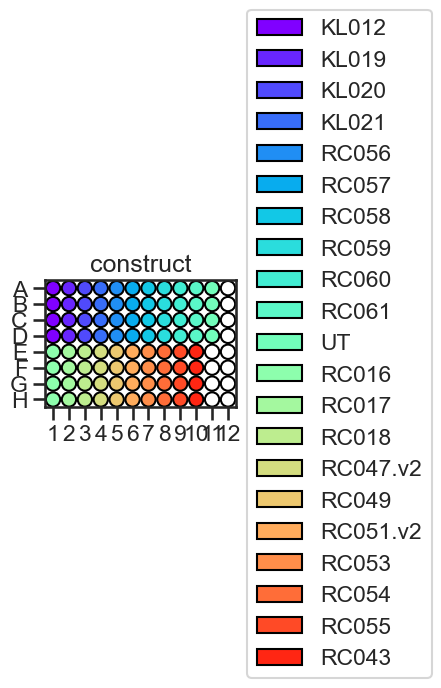

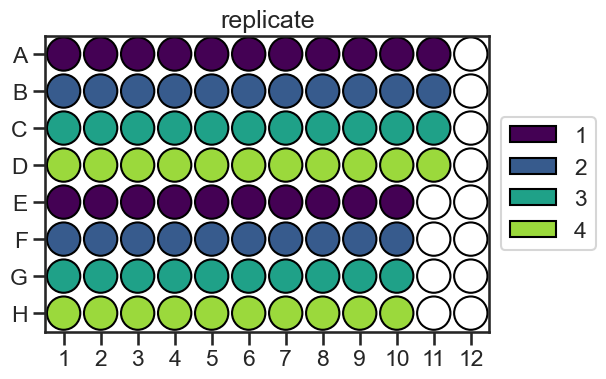

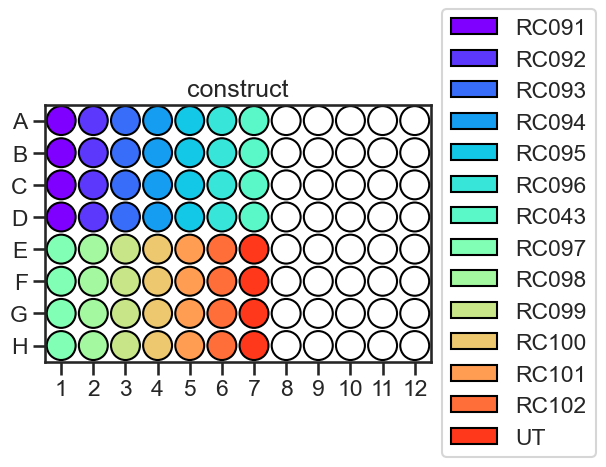

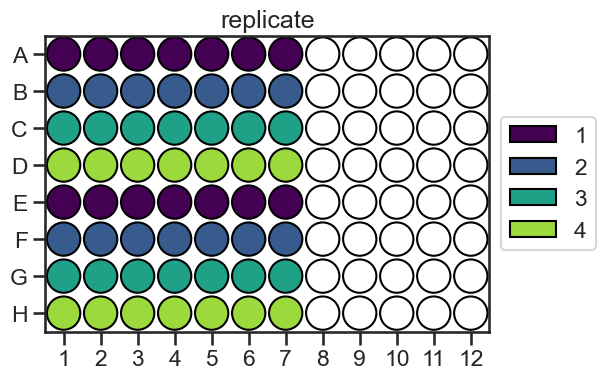

/Users/kaseylove/Desktop/code/miR-iFFL/env/lib/python3.12/site-packages/rushd/plot.py:142: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


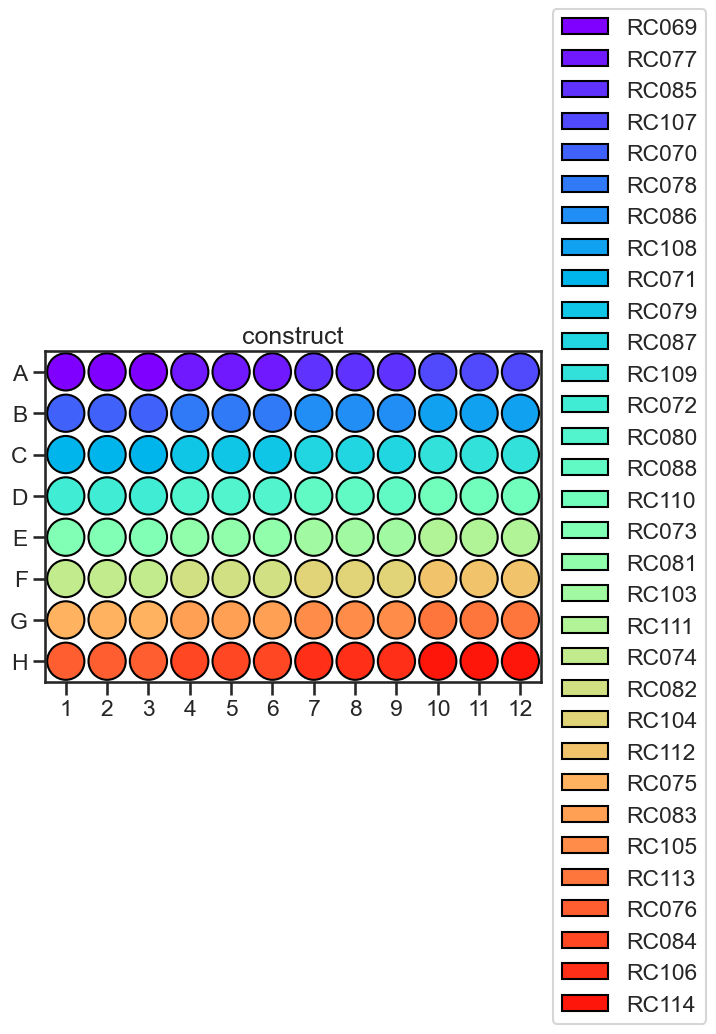

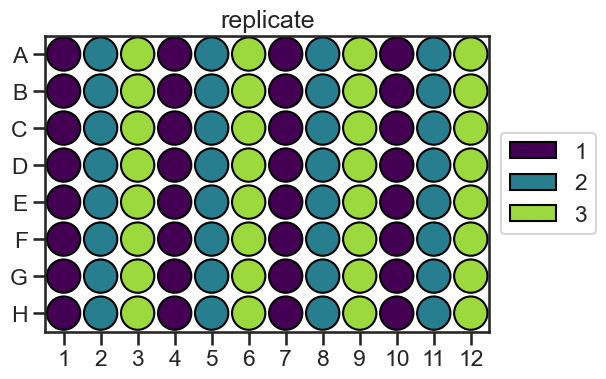

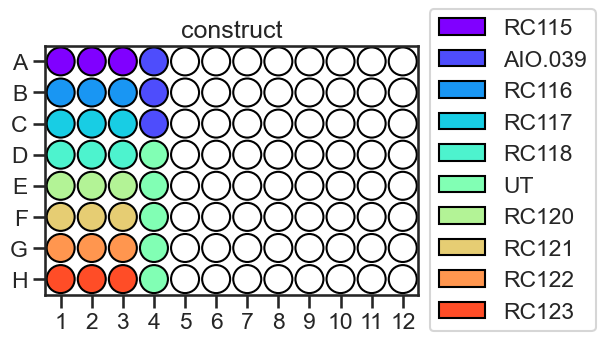

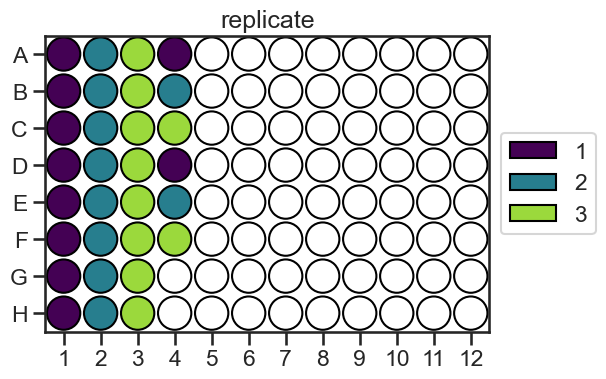

/Users/kaseylove/Desktop/code/miR-iFFL/env/lib/python3.12/site-packages/rushd/plot.py:142: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


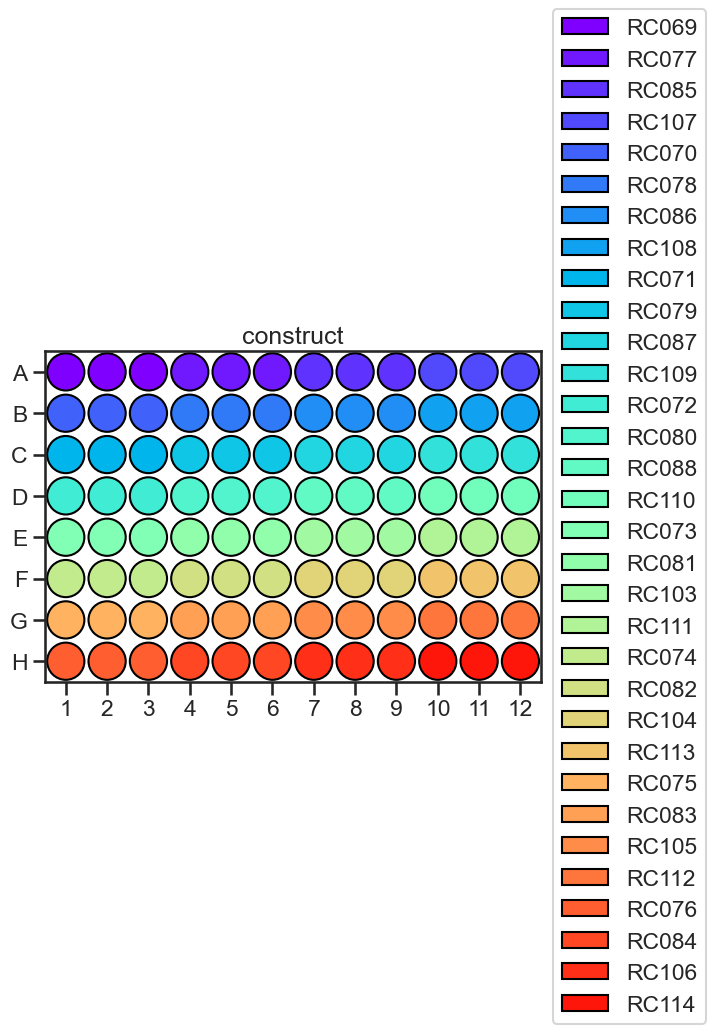

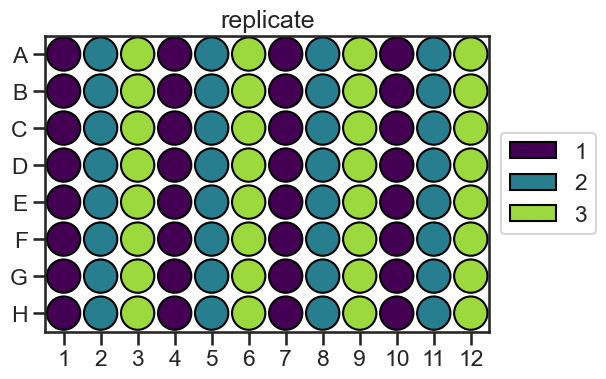

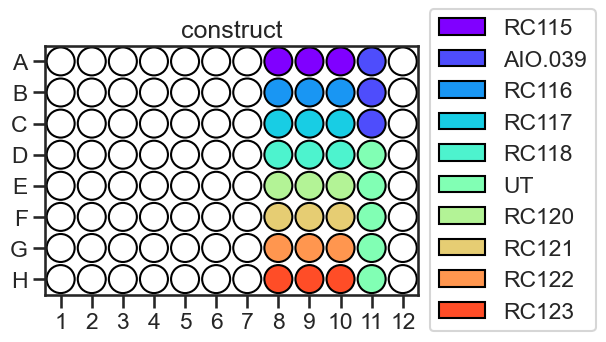

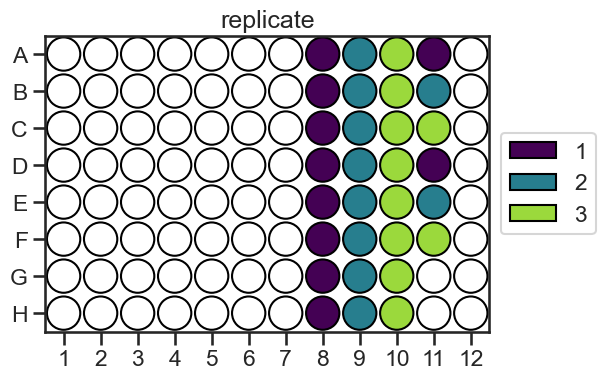

{'construct', 'replicate'}

In [14]:
base_path = rd.datadir/'instruments'/'data'/'attune'/'kasey'

exp45_1_path = base_path/'2022.07.15_exp45'
exp45_2_path = base_path/'2023.01.14_exp45.2'/'export'
exp45_3_path = base_path/'2023.02.10_exp45.3'/'export'

exp55_1_path = base_path/'2023.01.14_exp55'/'export'
exp55_2_path = base_path/'2023.02.10_exp55.2'/'export'
exp55_3_path = base_path/'2024.03.18_exp55.3'/'export'

exp67_1_path = base_path/'2023.06.15_exp67'/'export'
exp67_2_path = base_path/'2023.06.17_exp67.2'/'export'
exp67_3_path = base_path/'2024.03.18_exp67.3'/'export'

plates = pd.DataFrame({
    'data_path': [exp45_1_path/'293T'/'export', exp45_2_path, exp45_3_path,
                  exp55_1_path, exp55_2_path, exp55_3_path,
                  exp67_1_path/'plate1', exp67_1_path/'plate2', exp67_2_path/'plate1', exp67_2_path/'plate2', exp67_3_path/'plate1', exp67_3_path/'plate2'],
    'yaml_path': ([exp45_1_path/'exp45_wells2.yaml', exp45_2_path/'exp45.2_wells2.yaml', exp45_2_path/'exp45.2_wells2.yaml'] + 
                  [exp55_1_path/'exp55_wells2.yaml']*3 + 
                  [exp67_1_path/'exp67_plate1_wells2.yaml', exp67_1_path/'exp67_plate2_wells2.yaml']*2 + [exp67_3_path/'exp67.3_plate1_wells.yaml', exp67_3_path/'exp67.3_plate2_wells.yaml']),
    'biorep': [1, 2, 3,
               1, 2, 3,
               1, 1, 2, 2, 3, 3],
    'exp': ['exp45', 'exp45.2', 'exp45.3',
            'exp55', 'exp55.2', 'exp55.3',
            'exp67', 'exp67', 'exp67.2', 'exp67.2', 'exp67.3', 'exp67.3']
})

output_path = rd.rootdir/'output'/'controller-tuning-transfections'
cache_path = rd.rootdir/'output'/'controller-tuning-transfections'/'data.gzip'

metadata_keys = set()
for p in plates['yaml_path'].unique():
    rd.plot.plot_well_metadata(p)
    metadata_keys.update(rd.flow.load_well_metadata(p).keys())
display(metadata_keys)

In [15]:
# Load data
data = pd.DataFrame()
if cache_path.is_file(): data = pd.read_parquet(cache_path)
else: 
    data = rd.flow.load_groups_with_metadata(plates)

    # Remove unneeded columns and negative channel values
    channel_list = ['mCherry-A','mRuby2-A','FSC-A','SSC-A','tagBFP-A','mGL-A']
    for c in data.columns:
        if not(c in (list(plates.columns) + channel_list + list(metadata_keys))):
            data.drop(columns=c, inplace=True)
    for c in channel_list: data = data[data[c]>0]
    
    data.dropna(inplace=True)
    data.to_parquet(rd.outfile(cache_path))
display(data)

,construct,replicate,FSC-A,SSC-A,mGL-A,tagBFP-A,mRuby2-A,mCherry-A,biorep,exp
0,RC053,3,379476.0,163828.0,83.0,62.0,69.0,82.0,1,exp45
1,RC053,3,365912.0,69607.0,100.0,347.0,578.0,1029.0,1,exp45
3,RC053,3,289644.0,56371.0,94.0,933.0,300.0,623.0,1,exp45
6,RC053,3,325092.0,144351.0,72.0,1123.0,464.0,773.0,1,exp45
8,RC053,3,267512.0,109436.0,9.0,140.0,206.0,395.0,1,exp45
...,...,...,...,...,...,...,...,...,...,...
22700117,RC123,1,522902.0,170526.0,79.0,109.0,2971.0,1145.0,3,exp67.3
22700118,RC123,1,423154.0,168755.0,944.0,11.0,2012.0,747.0,3,exp67.3
22700121,RC123,1,476414.0,216149.0,2007.0,52.0,13367.0,5906.0,3,exp67.3
22700124,RC123,1,384825.0,82122.0,221.0,66.0,5787.0,2431.0,3,exp67.3


In [16]:
# Add metadata for constructs
metadata = base.get_metadata('construct-metadata.csv')
data = data.merge(metadata, how='left', on='construct')
display(data)

,construct,replicate,FSC-A,SSC-A,mGL-A,tagBFP-A,mRuby2-A,mCherry-A,biorep,exp,promoter,name,ts,miR,ts_num,ts_kind,design,group,color
0,RC053,3,379476.0,163828.0,83.0,62.0,69.0,82.0,1,exp45,CMV,CMV-TS.FF5x4-MCP-mCherry-miR.FF5-bGH,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587..."
1,RC053,3,365912.0,69607.0,100.0,347.0,578.0,1029.0,1,exp45,CMV,CMV-TS.FF5x4-MCP-mCherry-miR.FF5-bGH,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587..."
2,RC053,3,289644.0,56371.0,94.0,933.0,300.0,623.0,1,exp45,CMV,CMV-TS.FF5x4-MCP-mCherry-miR.FF5-bGH,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587..."
3,RC053,3,325092.0,144351.0,72.0,1123.0,464.0,773.0,1,exp45,CMV,CMV-TS.FF5x4-MCP-mCherry-miR.FF5-bGH,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587..."
4,RC053,3,267512.0,109436.0,9.0,140.0,206.0,395.0,1,exp45,CMV,CMV-TS.FF5x4-MCP-mCherry-miR.FF5-bGH,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053149,RC123,1,522902.0,170526.0,79.0,109.0,2971.0,1145.0,3,exp67.3,EFS,EFS-TS.FF4x1-mRuby2-bGH,FF4x1,none,1.0,T,0.0,ts5,purple
7053150,RC123,1,423154.0,168755.0,944.0,11.0,2012.0,747.0,3,exp67.3,EFS,EFS-TS.FF4x1-mRuby2-bGH,FF4x1,none,1.0,T,0.0,ts5,purple
7053151,RC123,1,476414.0,216149.0,2007.0,52.0,13367.0,5906.0,3,exp67.3,EFS,EFS-TS.FF4x1-mRuby2-bGH,FF4x1,none,1.0,T,0.0,ts5,purple
7053152,RC123,1,384825.0,82122.0,221.0,66.0,5787.0,2431.0,3,exp67.3,EFS,EFS-TS.FF4x1-mRuby2-bGH,FF4x1,none,1.0,T,0.0,ts5,purple


Draw gates based on untransfected population, then gate transfected cells

In [17]:
gates = pd.DataFrame()
for channel in ['tagBFP-A', 'mGL-A', 'mCherry-A', 'mRuby2-A']:
    gates[channel] = data[data['construct']=='UT'].groupby(['exp'])[channel].apply(lambda x: x.quantile(0.999))
gates.reset_index(inplace=True)

# Add missing gates
gates.loc[gates['exp']=='exp67.2', 'mGL-A'] = gates.loc[gates['exp']=='exp67', 'mGL-A'].values[0]
gates.loc[gates['exp']=='exp67.2', 'mRuby2-A'] = gates.loc[gates['exp']=='exp67', 'mRuby2-A'].values[0]

# Indicate which channels are relevant for each experiment
gates.sort_values(['exp'], inplace=True)
gates['marker'] = ['tagBFP-A']*6 + ['mGL-A']*3
gates['output'] = ['mCherry-A']*6 + ['mRuby2-A']*3

display(gates)

,exp,tagBFP-A,mGL-A,mCherry-A,mRuby2-A,marker,output
0,exp45,226.958,181.000,226.895,397.517,tagBFP-A,mCherry-A
1,exp45.2,218.000,180.000,212.851,332.000,tagBFP-A,mCherry-A
2,exp45.3,218.726,182.726,211.726,333.452,tagBFP-A,mCherry-A
3,exp55,223.000,185.000,216.000,347.398,tagBFP-A,mCherry-A
4,exp55.2,242.495,184.000,217.330,332.320,tagBFP-A,mCherry-A
5,exp55.3,283.297,240.188,251.000,343.970,tagBFP-A,mCherry-A
6,exp67,286.916,251.916,258.916,339.832,mGL-A,mRuby2-A
7,exp67.2,299.830,251.916,4571.565,339.832,mGL-A,mRuby2-A
8,exp67.3,285.000,256.484,255.000,370.484,mGL-A,mRuby2-A


Gate data per experiment based on transfection marker expression

In [18]:
data = data.groupby('exp')[data.columns].apply(lambda x: base.gate_data(x,gates))
data.reset_index(inplace=True, drop=True)
df = data[data['expressing']]
display(df)

,construct,replicate,FSC-A,SSC-A,mGL-A,tagBFP-A,mRuby2-A,mCherry-A,biorep,exp,...,ts,miR,ts_num,ts_kind,design,group,color,expressing,marker,output
1,RC053,3,365912.0,69607.0,100.0,347.0,578.0,1029.0,1,exp45,...,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587...",True,347.0,1029.0
2,RC053,3,289644.0,56371.0,94.0,933.0,300.0,623.0,1,exp45,...,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587...",True,933.0,623.0
3,RC053,3,325092.0,144351.0,72.0,1123.0,464.0,773.0,1,exp45,...,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587...",True,1123.0,773.0
9,RC053,3,289747.0,67089.0,40.0,6653.0,712.0,1309.0,1,exp45,...,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587...",True,6653.0,1309.0
10,RC053,3,365432.0,104151.0,31.0,11038.0,701.0,1526.0,1,exp45,...,FF5x4,miR.FF5,4.0,T,3.0,controller,"(0.9071207769679174, 0.5081083182774243, 0.587...",True,11038.0,1526.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7053146,RC123,1,526960.0,110055.0,576.0,11.0,4059.0,1659.0,3,exp67.3,...,FF4x1,none,1.0,T,0.0,ts5,purple,True,576.0,4059.0
7053147,RC123,1,354382.0,97005.0,1202.0,92.0,45029.0,19634.0,3,exp67.3,...,FF4x1,none,1.0,T,0.0,ts5,purple,True,1202.0,45029.0
7053148,RC123,1,421625.0,90491.0,818.0,117.0,8035.0,3501.0,3,exp67.3,...,FF4x1,none,1.0,T,0.0,ts5,purple,True,818.0,8035.0
7053150,RC123,1,423154.0,168755.0,944.0,11.0,2012.0,747.0,3,exp67.3,...,FF4x1,none,1.0,T,0.0,ts5,purple,True,944.0,2012.0


## Summarize

Create summary plots of common metrics across all the data.

Note that these plots are mainly FacetGrids, not artisanal plots suitable for figures/presentations.